# **Diplomado IA: Inteligencia Artificial I - Parte 2**. <br> Laboratorio 4: Data Augmentation, Transferencia de conocimiento y Finetuning
---
---

**Profesores:**
- Julio Hurtado
- Felipe del Río

**Ayudante:**
- TBD
---
---

# **Instrucciones Generales**

El siguiente práctico se puede realizar en **parejas**. Solo uno debe realizar la entrega. El formato de entregar es el **archivo .ipynb con todas las celdas ejecutadas**. Todas las preguntas deben ser respondida en celdas de texto. No se aceptará el _output_ de una celda de código como respuesta.

**Nombre compañero 1:** FRANCISCO MENA

**Nombre compañero 2:** COMPLETAR

**Fecha de entrega: Miércoles 2 de diciembre.**

El siguiente práctico cuanta con 2 secciones donde cada una contendrá 1 o más actividades a realizar. Algunas actividades correspondrán a escribir código y otras a responder preguntas. 

**Importante.** Para facilitar su ejecución, cada sección puede ser ejecutada independientemente.

Se recomienda **fuertemente** revisar las secciones donde se entrega código porque algunas actividades de código pueden reutilizar el mismo código pero con cambios en algunas líneas.



# **Agenda**

>[Diplomado IA: Inteligencia Artificial I - Parte 2.  Laboratorio 4: Data Augmentation, Transferencia de conocimiento y Finetuning](#scrollTo=tHopPtVaNF1K)

>[Instrucciones Generales](#scrollTo=uIdAKAdELPSl)

>[Agenda](#scrollTo=kEloa5uXLIPK)

>[Actividad I: Imágenes](#scrollTo=HOa9JfE2WfUb)

>>[Preámbulo](#scrollTo=CDBGNG3R4I8r)

>>[Primeros Pasos](#scrollTo=7AJawpaKoGdK)

>>>[Dataset](#scrollTo=OZDH2UsI89UR)

>>>[Entrenamos un Modelo Base](#scrollTo=-QFHlOSR9BYd)

>>[Aumentación de Datos](#scrollTo=mMygBiPcsCIz)

>>>[Reflexiones](#scrollTo=SAbGkA9R0r9m)

>>>[Recortes](#scrollTo=psPyBfTK0xsQ)

>>>[Rotaciones](#scrollTo=gESEMUPg0_xQ)

>>>[Transformaciones Afín](#scrollTo=QkBQAG8EX5sf)

>>>[Composición de transformaciones](#scrollTo=EVxbSK-Q1EQT)

>>>[Transformaciones custom](#scrollTo=7nIxe7hHHvfu)

>>>[Ejercicio I](#scrollTo=4f--FBKjlszW)

>>[Transfer Learning y Finetuning](#scrollTo=UQhGTF-8IB71)

>>>[Finetuning](#scrollTo=131YF5zEX4_R)

>>>[Ejercicio II](#scrollTo=ZzomWbLeh2YB)

>[Actividad II: Texto](#scrollTo=_hc0eXMnHZsC)

>>[Preámbulo](#scrollTo=O4Qfqe2Sr1Mc)

>>[Primeros Pasos](#scrollTo=TjVrxQAUw7iB)

>>>[Dataset](#scrollTo=TjVrxQAUw7iB)

>>[Modelo Base](#scrollTo=dvMVR6Ux5YGA)

>>[Finetuning](#scrollTo=NiztGI2ILH06)

>>[Ejercicio III](#scrollTo=4VGwV1D6UlxF)

>[Anexo](#scrollTo=kX7ogfKfhOfl)

>>[¿Cómo entrenar algunas capas del modelo?](#scrollTo=toCtK7zTeXNc)



# Actividad I: Imágenes

En esta actividad aplicaremos lo que vimos en clase para un problema de clasificación de imágenes. Veremos como aplicar *data augmentation* y usar finetuning para este dominio en particular.

<small>Agradecemos a Hernán Valdivieso por su script para descargar archivos desde Google Drive.</small>

## Preámbulo

Primero debemos copiar el dataset hacia colab para luego decomprimirlo dentro del directorio `data`, que recién creamos. También importamos algunas de las librerías que ocuparemos durante esta actividad.

In [1]:
![[ ! -f google_api.py ]] && wget -q --show-progress https://raw.githubusercontent.com/Hernan4444/MyScripts/master/google_drive/google_api.py
!mkdir -p data

In [2]:
import os
from google_api import download_file_without_authenticate

# Descargamos nuestros datos para ser utilizados en este notebook.
if not os.path.exists('lab4.zip'): 
    download_file_without_authenticate(
        '1NjcTV1SeZgYWOAZG-ig2NBpYP5EyTy8Z', 'data/jigsaw-toxic-comment-classification-challenge.zip')
    download_file_without_authenticate(
        '1ye0M-KnVtUbpIgGjogIjgWx0vReCthWA', 'data/flowers.zip')
    
!unzip -nq data/\*.zip -d data


2 archives were successfully processed.


In [3]:
import random
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# No tocar este código
random.seed(1666)
rng_state = np.random.get_state()
np.random.seed(1666)
torch.manual_seed(1666)
torch.cuda.manual_seed(1666)

## Primeros Pasos

En la gran mayoría de aplicaciones con las que se encontraran en el mundo real, difícilmente podrán tener una cantidad de **datos etiquetados** suficientes para entrenar un red neuronal profunda como las que han visto hasta ahora. 

*En* esta actividad práctica veremos como enfrentarnos a esta situación utilizando las herramientas que vimos en clase y la librería PyTorch

### Dataset 

Trabajaremos con el dataset **flowers**, el cual ya utilizaron anteriormente. Este dataset está compuesto por imágenes de flores centradas. Las imágenes son de tamaño variable. Y la tarea a realizar es la de clasificación de la especie que aparece en cada imágen.

Si ejecutaron el código anterior, ya tenemos nuestro dataset en el directorio `data`.

Luego, debemos crear un objeto de la clase `Dataset`, para eso nos ayudaremos con la clase `torchvision.datasets.ImageFolder`, que hereda de esta, y utilizaremos durante esta actividad. En este caso ya tenemos divididos los distintos sets que utilizaremos (`train`, `val` y `test`), cada uno en su propio directorio y además agregamos un directorio `all`, que contiene la totalidad de los datos que también utilizaremos.

In [5]:
from torchvision.datasets import ImageFolder

root_dir = 'data/flowers'
flowers_dataset = ImageFolder(f'{root_dir}/all/')
train_dataset = ImageFolder(f'{root_dir}/train/')
val_dataset = ImageFolder(f'{root_dir}/val/')
test_dataset = ImageFolder(f'{root_dir}/test/')

Exploremos los datos para que podamos ver algunas de las características que estos tienen. Primero veamos con cuantos datos contamos.

In [6]:
for split, ds in [('totales', flowers_dataset), ('train', train_dataset), ('val', val_dataset), ('test', test_dataset)]:
    print('{:<18s}{:>6,d}'.format(f'Imágenes {split}:', len(ds)))

Imágenes totales:  8,189
Imágenes train:    5,687
Imágenes val:      1,224
Imágenes test:     1,278


Podemos ver algunas de las clases, aleatoriamente elegidas, en que están etiquetadas nuestras imágenes. Además veamos como se ven los datos, elijamos ejemplos aleatorios con su clase y mostremoslos. 

**Insight.** Siempre es importante revisar manualmente los datos. Así nos hacemos una mejor idea de las características del dataset y podemos sacar *insights* que nos ayuden a mejorar el rendimiento de los modelos que vayamos a entrenar.

In [7]:
for label in random.choices(flowers_dataset.classes, k=10):
    print(label)

mallow
red ginger
magnolia
artichoke
frangipani
trumpet creeper
columbine
corn poppy
bishop of llandaff
magnolia


Tamaño imagen: 666x500
Etiqueta:      tree mallow


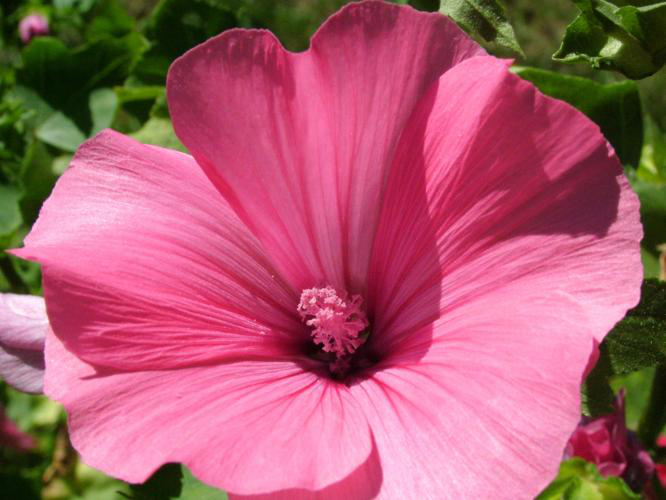

In [8]:
ridx = random.randint(0, len(flowers_dataset))
sample_img, sample_class = flowers_dataset[ridx]

w, h = sample_img.size
class_ = flowers_dataset.classes[sample_class]

print(f'Tamaño imagen: {w}x{h}')
print(f'Etiqueta:      {class_}')
sample_img

### Entrenamos un Modelo Base

Habiendo explorados los datos, prosigamos a entrenar un modelo base. Este modelo nos servirá para poder tener un punto de comparación, y así tener una mejor idea de cuanto ayuda usar las técnicas que vimos en clases. Entrenaremos un modelo típico para esta tarea, una [ResNet18](https://arxiv.org/abs/1512.03385) que es un modelo simple y liviano para mostrar. De todas maneras una mejora simple y directa que se puede hacer es utilizar una *ResNet* de mayor número de capas, i.e. 34, 50, 101 o 152, lo cual debería mejorar el rendimiento de clasificador.

Partiremos inicializando los distintos hiperparámetros que utilizaremos durante este práctico.

In [9]:
import torch.nn as nn

batch_size = 128 #@param {type:"number"}
learning_rate = 5E-4 #@param {type:"number"}
n_epochs = 5 # @param {type:"slider", min:1, max:20, step:1}

In [10]:
criterion = nn.CrossEntropyLoss()
n_classes = len(flowers_dataset.classes)

Creemos los data loaders, los cuales nos permitiran armar batches para el entrenamiento. Además nos ayudarán entregandonos los datos de forma desordenada o aleatoria, como habrán visto en clases anteriores, esto siempre es recomendable pero solo es necesario para el set de entrenamiento.

In [11]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True), # shuffle = aleatorio 
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False),
}

Para ahorrarnos trabajo, utilizaremos transformaciones. En primera instancia, solo nos preocuparemos de que todas las imágenes sean del mismo tamaño y están normalizadas. Además nos ayudaremos transformando automáticamente la imagen a un `torch.Tensor`, el cual podremos utilizar para el entrenamiento. Más adelante las utilizaremos para hacer *Data Augmentation*.

In [12]:
from torchvision import transforms

# Pixel medio y std de Imagenet 
mean_pixel = [0.485, 0.456, 0.406]
std_pixel = [0.229, 0.224, 0.225]

to_normalized_tensor = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_pixel, std=std_pixel),
            ])
train_dataset.transform = transforms.Compose([  
                transforms.Resize([224, 224]),
                to_normalized_tensor
            ])
val_dataset.transform = transforms.Compose([  
                transforms.Resize([224, 224]),
                to_normalized_tensor
            ])
test_dataset.transform = transforms.Compose([  
                transforms.Resize([224, 224]),
                to_normalized_tensor
            ])

Además, crearemos varias funciones que nos ayudarán el entrenaminto de modelos reiteradas veces en este práctico. Les recomendamos que traten de entender cada una de estas funciones pues podrán reforzar conocimientos que ya han aprendido en el diplomado hasta ahora, pero para efectos de esta actividad no es necesario hacerlo.

In [13]:
import torchvision.models as models

def get_model(n_classes, pretrained=None):
    model = models.resnet18(pretrained=pretrained)
    model.fc = nn.Linear(in_features=512, out_features=n_classes, bias=True)
    model.to(device) # Envíamos el modelo a la GPU si está disponible
    return model

def run_epoch(phase, model, loader, criterion, optimizer=None):
    n_batches = len(loader)
    if phase == 'train':
        model.train()
    elif phase == 'val' or 'test':
        model.eval()
        
    cum_loss = 0.0
    cum_acc = 0.0
    for n_batch, (x, y) in enumerate(loader, start=1):
        if phase == 'train': # Limpiamos los gradientes solo al entrenar
            optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)
        result = model(x) # Aquí se ejecuta nuestro modelo

        loss = criterion(result, y) # Calculamos la pérdida
        cum_loss += loss.item()
        _, preds = torch.max(result, 1) # Nuestra predicción es la salida de mayor valor entre las 10 posibles
        cum_acc += torch.sum(preds == y.data)
        if phase == 'train':
            loss.backward() # Hacemos backpropagation solo en train
            optimizer.step() # Actualizamos parámetros solo en train

        current_cum_loss = cum_loss / n_batch
        current_cum_acc = 100 * cum_acc / (n_batch * batch_size)
        print(f'\r{phase.upper()}-Batch {n_batch}/{n_batches} '
              f'Loss: {current_cum_loss:.4f} Acc: {current_cum_acc:.2f}%', end='')
    
    epoch_loss = float(cum_loss / n_batch)
    epoch_acc = float(100 * cum_acc / (n_batch * batch_size))
    return epoch_loss, epoch_acc

def run_training(model, loaders, optimizer, criterion, n_epochs):
    phases = ['train', 'val']
    history = {
        'train': {'loss': [], 'acc': []},
        'val': {'loss': [], 'acc': []}
    }

    print(f"Validating model before training")
    val_loss, val_acc = run_epoch('val', model, loaders['val'], criterion)
    print()
    history['val']['loss'].append(val_loss)
    history['val']['acc'].append(val_acc)
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch N°{epoch}")
        for phase in phases:
            epoch_loss, epoch_acc = run_epoch(phase, model, loaders[phase], criterion, optimizer=optimizer)

            # Registramos las pérdidas y accuracy por época, por fase
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)
            print("")

    return history

def run_testing(model, loader, criterion, n_epochs):
    test_loss, test_acc = run_epoch('test', model, loader, criterion, optimizer=optimizer)
    print(f'\n\nTest loss: {test_loss:.4f}, Test acc.: {test_acc:.2f}\n')
    return {'loss': test_loss, 'acc': test_acc}

Definamos también algunas funciones que nos ayudarán a visualizar el entrenamiento y sus resultados de mejor forma.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from PIL import Image

def graph_metrics(metricas_test, metricas_train, title=''):
    fig, ax = plt.subplots()
    plt.style.use('seaborn-white')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
    plt.plot(range(1, int(len(metricas_train)+1)), metricas_train, marker='o')
    plt.plot(range(int(len(metricas_test))), metricas_test, marker='o')
    plt.legend(['Train', 'Val'])
    plt.title(title)
    plt.show()

def graph_training_metrics(history):
    for metric in ['loss', 'acc']:
        title = f'{metric.capitalize()} vs N° Épocas'
        graph_metrics(history['val'][metric], history['train'][metric], title=title)

def print_report(train_history, test_performance):
    graph_training_metrics(train_history)

    train_loss = train_history['train']['loss'][-1]
    train_acc = train_history['train']['acc'][-1]
    val_loss = train_history['val']['loss'][-1]
    val_acc = train_history['val']['acc'][-1]
    test_loss = test_performance['loss']
    test_acc = test_performance['acc']
    print(f'Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%')

def bold(text):
  return '\033[1m' + text + '\033[0m'

def show_prediction(model, dataset, sample_idx=None, topk=5):
    if sample_idx is None:
        sample_idx = random.randrange(len(dataset))

    image_path, label = dataset.samples[0]
    label = flowers_dataset.classes[label]

    x, y = dataset[sample_idx]
    x = x.to(device)
    x = x.unsqueeze(dim=0)
    probs = nn.functional.softmax(model(x), dim=1)
    topk_probs, topk_classes = torch.topk(probs, k=topk)
    print(bold('Ground Truth'))
    print(label, end='\n\n')

    print(bold(f'Top-{topk} Predictions'))
    for prob, label_idx in zip(topk_probs.squeeze(), topk_classes.squeeze()):
        label_idx, prob = int(label_idx), float(prob)
        print('{:<19} (p={:.4f})'.format(flowers_dataset.classes[label_idx], prob))

    print()
    return Image.open(image_path)

Luego, utilizamos las funciones que acabamos de crear, para entrenar nuestro primer  y ver como le va.

In [15]:
from torch.optim import Adam

model = get_model(n_classes=n_classes)
optimizer = Adam(model.parameters(), lr=learning_rate)

history = run_training(model, loaders, optimizer, criterion, n_epochs)

Validating model before training
VAL-Batch 10/10 Loss: 5.2827 Acc: 1.72%
Epoch N°1
TRAIN-Batch 45/45 Loss: 3.4986 Acc: 17.88%
VAL-Batch 10/10 Loss: 3.5254 Acc: 15.55%
Epoch N°2
TRAIN-Batch 45/45 Loss: 2.6155 Acc: 32.31%
VAL-Batch 10/10 Loss: 2.7328 Acc: 29.22%
Epoch N°3
TRAIN-Batch 45/45 Loss: 2.2890 Acc: 39.27%
VAL-Batch 10/10 Loss: 2.5282 Acc: 33.44%
Epoch N°4
TRAIN-Batch 45/45 Loss: 2.0258 Acc: 44.69%
VAL-Batch 10/10 Loss: 2.2737 Acc: 38.83%
Epoch N°5
TRAIN-Batch 45/45 Loss: 1.7911 Acc: 51.18%
VAL-Batch 10/10 Loss: 2.1614 Acc: 40.23%


También procedemos a ver su rendimiento final en el set de test.

TEST-Batch 10/10 Loss: 2.1341 Acc: 43.36%

Test loss: 2.1341, Test acc.: 43.36



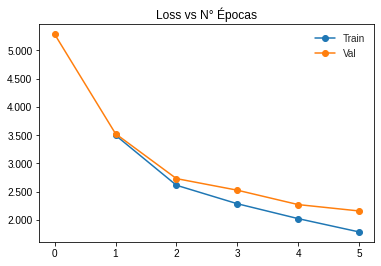

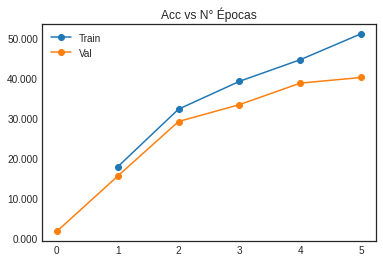

Train Loss: 1.7911 - Train Acc: 51.18%
Val Loss: 2.1614 - Val Acc: 40.23%
Test Loss: 2.1341 - Test Acc: 43.36%


In [16]:
test_performance = run_testing(model, loaders['test'], criterion, n_epochs)

print_report(history, test_performance)

Inspeccionemos la predicción del modelo para un ejemplo.

Ground Truth
alpine sea holly

Top-5 Predictions
lenten rose         (p=0.3223)
foxglove            (p=0.1286)
mallow              (p=0.0988)
lotus               (p=0.0549)
columbine           (p=0.0532)



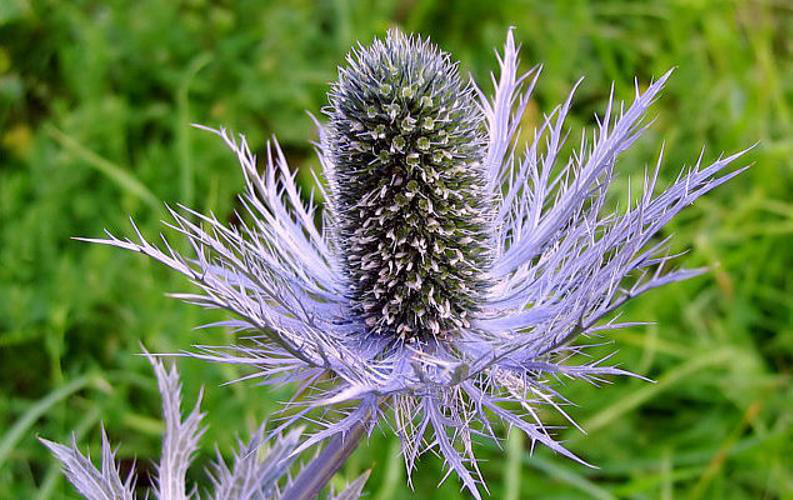

In [17]:
show_prediction(model, test_dataset)  # Si omiten el sample_idx este será elegido aleatoriamente

## Aumentación de Datos

Hasta ahora solo hemos repasado contenidos que ya habían visto, de manera que podamos tener un modelo con cual compararnos. Ahora veremos como utlizar *Data Augmentation*, para, en lo posible, mejorar el rendimiento de nuestro modelo.

Como vimos en clase podemos aumentar de forma artificial nuestro set de datos utilizando distintas técnicas. A continuación veremos algunas de las técnicas más utilizadas, veremos como se ven visualmente, cómo se aplican en el entrenamiento de forma fácil utilizando PyTorch y el resultado que estas tienen sobre el entrenamiento.

Para efectuar data augmentation en imágenes, PyTorch nos ayuda con la librería `tochvision.transforms`, esta librería no es exclusiva para este uso pero podemos aprovecharla para facilitarnos la vida ya que cuenta con las transformaciones más comunes que se hacen sobre imágenes en este contexto.

Crearemos funciones que nos permiten aplicarlas y visualizar su resultado.

In [18]:
def n_sample_from_m_imgs(dataset, n_samples, m_images, rand=True):
    imgs = []
    for i in range(m_images):
        ridx = random.randint(0, len(dataset)) if rand else i
        sample_imgs = []
        for j in range(n_samples):
            sample_img, _ = dataset[ridx]
            sample_imgs.append(sample_img)
        imgs.append(sample_imgs)
    return imgs

def display_image_grid(images):
    rows = len(images)
    columns = len(images[0])

    figure, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(1.5 * columns, 1.5 * rows))
    for row_axes, row_imgs  in zip(axes, images):
        for ax, img in zip(row_axes, row_imgs):
            ax.imshow(img)
            ax.axis('off')

Ahora veamos el resultados de algunas de estas.

### Reflexiones

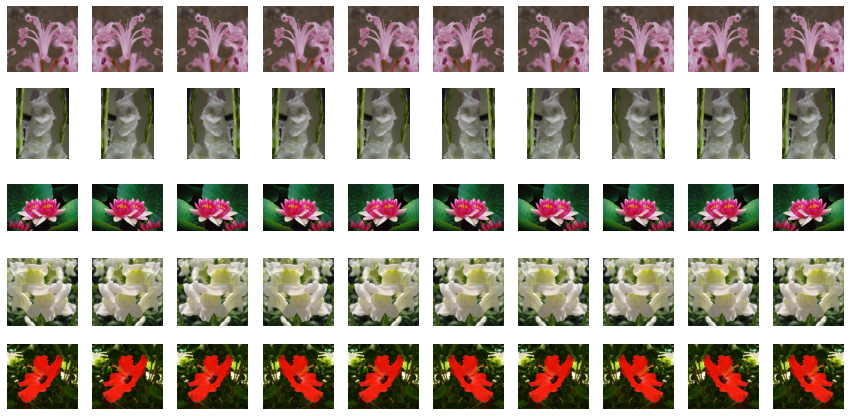

In [19]:
flowers_dataset.transform = transforms.RandomHorizontalFlip(p=0.5)

imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5)
display_image_grid(imgs)

### Recortes

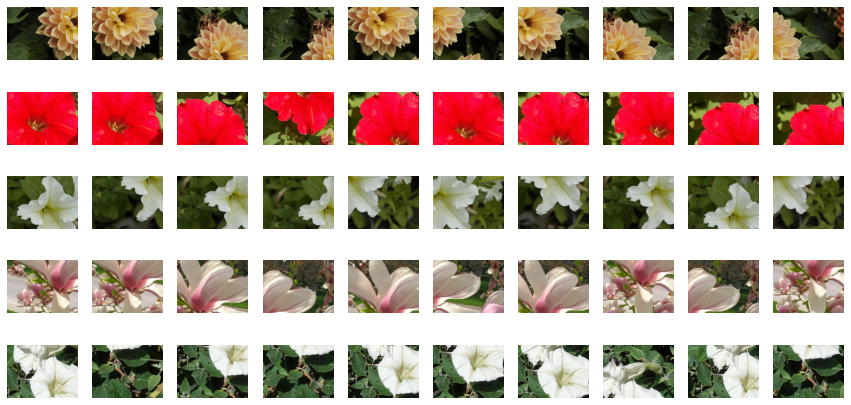

In [20]:
flowers_dataset.transform = transforms.RandomCrop(size=(240, 320), pad_if_needed=True)

imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5)
display_image_grid(imgs)

### Rotaciones

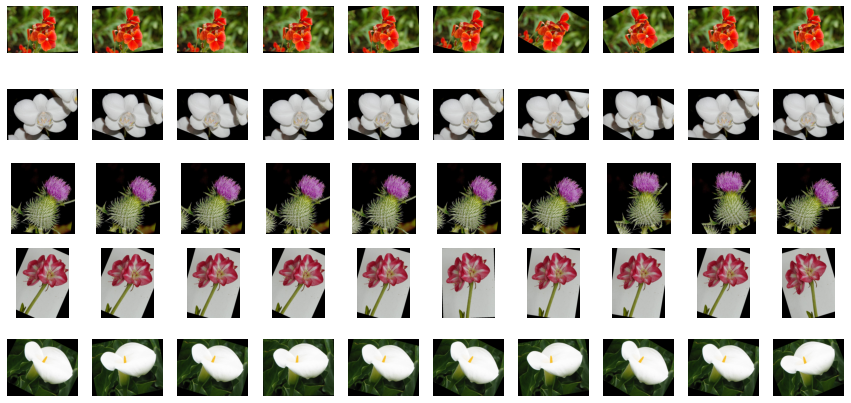

In [21]:
flowers_dataset.transform = transforms.RandomRotation((-30, 30))

imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5)
display_image_grid(imgs)

### Transformaciones Afín

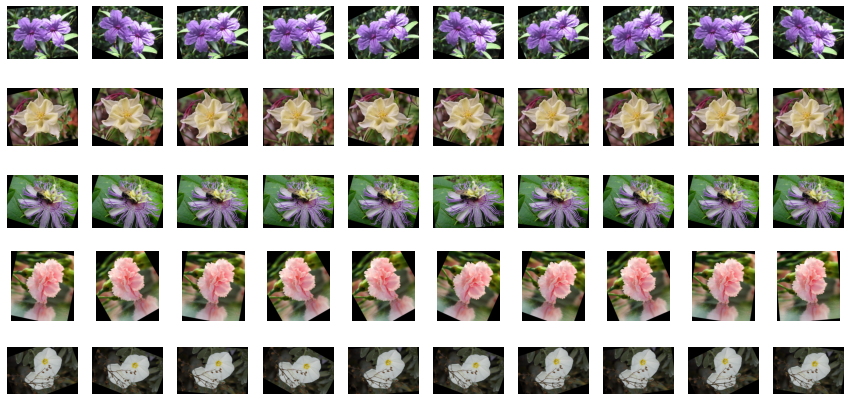

In [22]:
flowers_dataset.transform = transforms.RandomAffine(30)

imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5)
display_image_grid(imgs)

### Composición de transformaciones

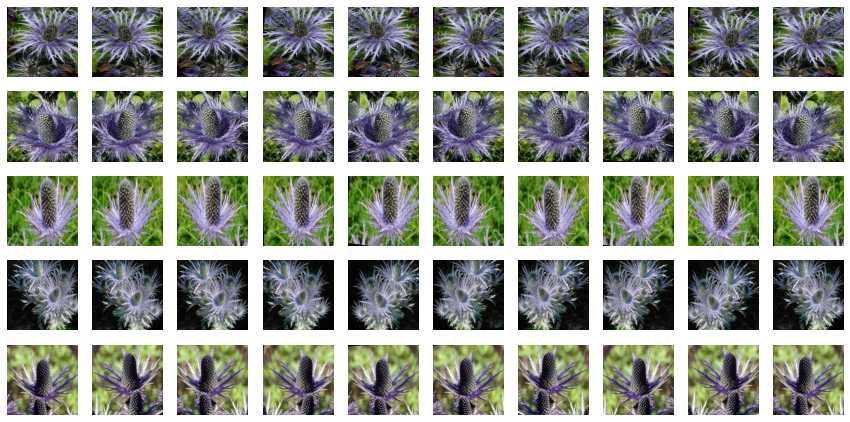

In [23]:
randomized_transforms = transforms.Compose([
    transforms.RandomRotation((-5, 5)), 
    transforms.Resize([256, 256]),
    transforms.RandomCrop(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
])

flowers_dataset.transform = randomized_transforms
imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5, rand=False)
display_image_grid(imgs)

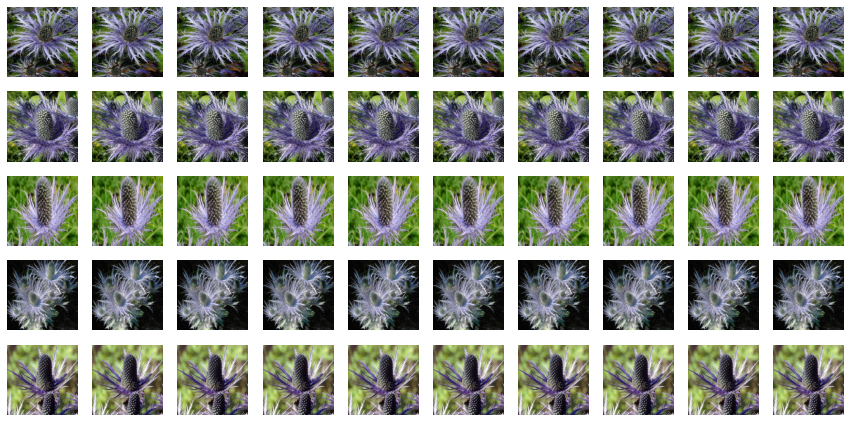

In [24]:
deterministic_transforms = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.CenterCrop(size=(224, 224)),
])

flowers_dataset.transform = deterministic_transforms
imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5, rand=False)
display_image_grid(imgs)

Otras formas de aplicar transformaciones es utilizando `torchvision.transforms.RandomApply`, que aplica las transformaciones que contiene con una probabilidad $p$ y `torchvision.transforms.RandomChoice`, que aleatoriamente elige una transformación de una lista y la aplica.

### Transformaciones custom
También, podemos crear nuestras transformaciones propias fácilmente de la siguiente forma: 

In [25]:
from torch.nn import Module

class MyTransformation(Module):
    def __init__(self):
        pass

    def __call__(self, x):
        # Must return an image or tensor
        pass

In [26]:
from PIL import Image

class AddGaussianNoise(Module):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def __call__(self, img):
        img = np.array(img)
        noise = np.random.normal(loc=self.mu, scale=self.sigma, size=img.shape)
        img = (img + noise).clip(0, 255).astype(np.uint8)
        return Image.fromarray(img)

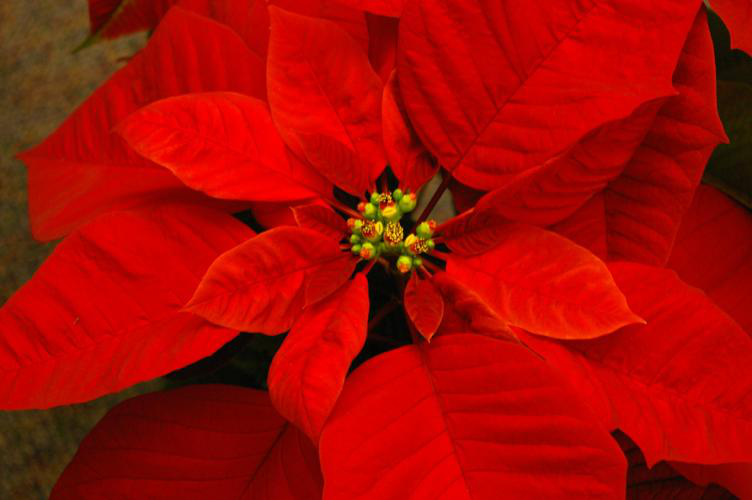

In [27]:
flowers_dataset.transform = None

ridx = random.randint(0, len(flowers_dataset))
sample_img, sample_class = flowers_dataset[ridx]
sample_img

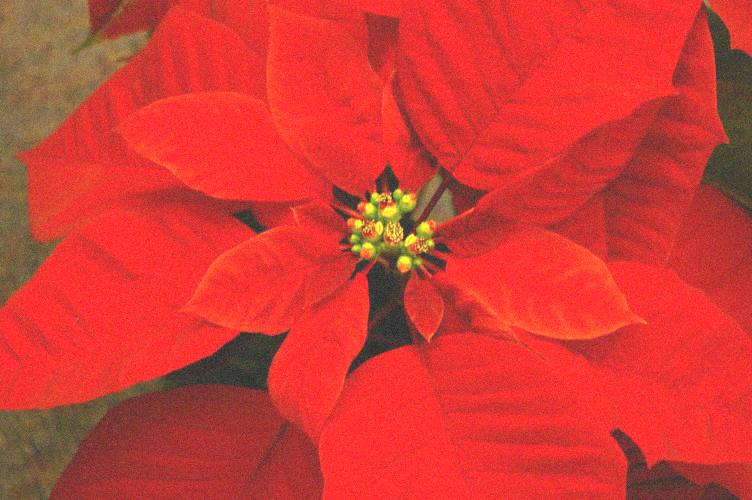

In [28]:
flowers_dataset.transform = AddGaussianNoise(50,10)

sample_img, sample_class = flowers_dataset[ridx]
sample_img

Ahora entrenaremos otro modelo utilizando data augmentation para ver como afecta en su rendimiento en test. 

Para esto, primero debemos agregar la transformaciones que nos faltan para que la salida de nuestro dataset venga en forma de tensor y esté normalizado, igual que en el primer entrenamiento.

In [29]:
train_dataset.transform = transforms.Compose([
    randomized_transforms,
    to_normalized_tensor     
])
val_dataset.transform = transforms.Compose([
    deterministic_transforms,
    to_normalized_tensor           
])
test_dataset.transform = transforms.Compose([
    deterministic_transforms,
    to_normalized_tensor             
])

Validating model before training
VAL-Batch 10/10 Loss: 5.1586 Acc: 3.36%
Epoch N°1
TRAIN-Batch 45/45 Loss: 3.5137 Acc: 18.30%
VAL-Batch 10/10 Loss: 3.5364 Acc: 14.84%
Epoch N°2
TRAIN-Batch 45/45 Loss: 2.6773 Acc: 30.42%
VAL-Batch 10/10 Loss: 2.7066 Acc: 28.59%
Epoch N°3
TRAIN-Batch 45/45 Loss: 2.3342 Acc: 38.23%
VAL-Batch 10/10 Loss: 2.6700 Acc: 31.25%
Epoch N°4
TRAIN-Batch 45/45 Loss: 2.0680 Acc: 44.64%
VAL-Batch 10/10 Loss: 2.3340 Acc: 35.23%
Epoch N°5
TRAIN-Batch 45/45 Loss: 1.9030 Acc: 46.74%
VAL-Batch 10/10 Loss: 2.1958 Acc: 40.78%
TEST-Batch 10/10 Loss: 2.1388 Acc: 41.56%

Test loss: 2.1388, Test acc.: 41.56



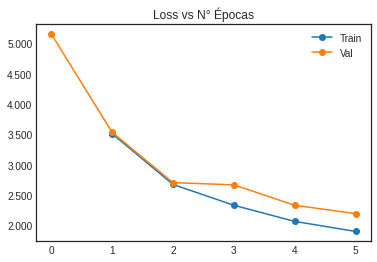

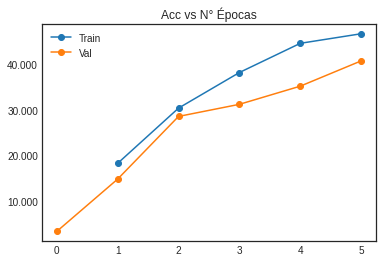

Train Loss: 1.9030 - Train Acc: 46.74%
Val Loss: 2.1958 - Val Acc: 40.78%
Test Loss: 2.1388 - Test Acc: 41.56%


In [30]:
aug_model = get_model(n_classes=n_classes)

aug_optimizer = Adam(aug_model.parameters(), lr=learning_rate)

aug_history = run_training(aug_model, loaders, aug_optimizer, criterion, n_epochs)
aug_test_performance = run_testing(aug_model, loaders['test'], criterion, n_epochs)

print_report(aug_history, aug_test_performance)

Ground Truth
alpine sea holly

Top-5 Predictions
mexican petunia     (p=0.1744)
sweet pea           (p=0.0906)
pelargonium         (p=0.0880)
pink primrose       (p=0.0847)
petunia             (p=0.0480)



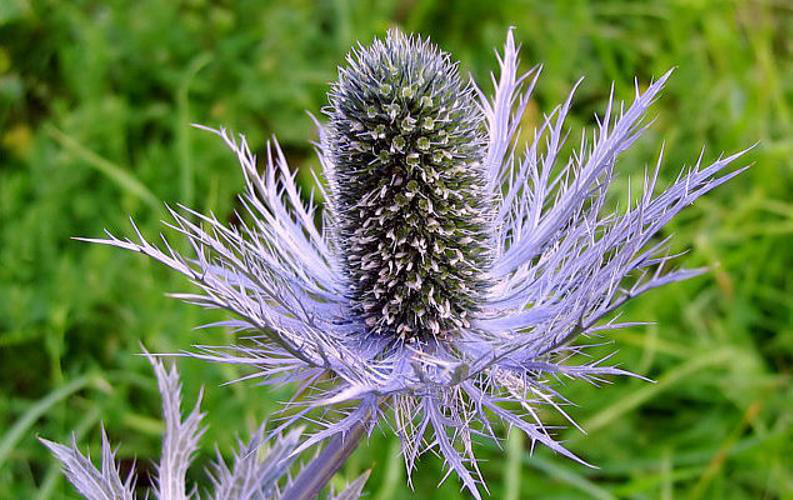

In [31]:
show_prediction(aug_model, test_dataset, sample_idx=166) # Si omiten el sample_idx este será elegido aleatoriamente

### **Ejercicio I**
Cree su propia transformación, esta debe recibir una imagen y devolverla reflejada verticalmente. Luego pruébela para entrenar un modelo descomentando el código a continuación (esta será aplicada aleatoriamente con probabilidad $p=0.5$). Para ser creado el objeto transformación **no** debe recibir ningún parámetro.
- ¿Cómo se compara el rendimiento con nuestro modelo base? ¿Y con el modelo entrenado con data augmentation que habíamos probado previamente?
- Analice brevemente el resultado obtenido brevemente.

**Alternativa.** Puede inventar su propia operación para esta actividad, pero en caso de hacerlo debe explicar brevemente lo que hace, también tener cuidado que el nombre de la transformación debe ser consistente en el código de entrenamiento a continuación.

**Ayuda.** Para realizar este ejercicio le recomendamos familiarizarse con la librería [`PIL`](https://pillow.readthedocs.io/en/stable/reference/), específicamente la función [`Image.transpose`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.transpose). Si encuentra una forma alternativa de realizar esta operación, no dude en usarla.

In [32]:
class VerticalFlipTransform(Module):
    def __init__(self):
        pass

    def __call__(self, img):
        return img.transpose(method=Image.FLIP_TOP_BOTTOM)

Visualice su transformación y pruebe entrenar un modelo utilizandola.



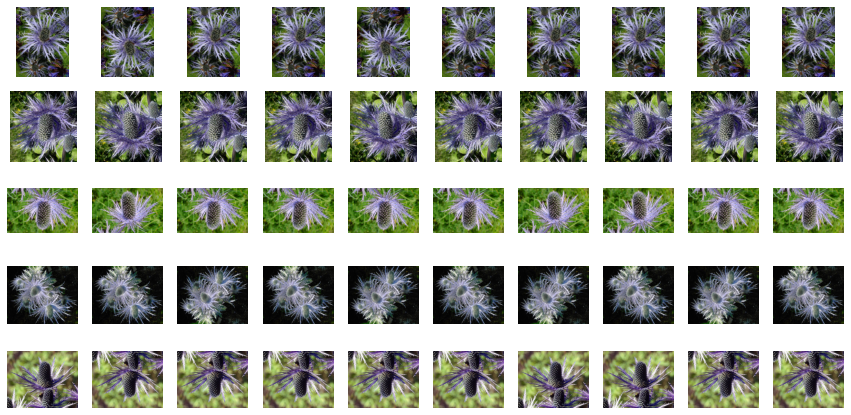

In [33]:
from torch.nn import ModuleList

flowers_dataset.transform = transforms.RandomApply(
     ModuleList([VerticalFlipTransform()]), p=0.5)

imgs = n_sample_from_m_imgs(flowers_dataset, n_samples=10, m_images=5, rand=False)
display_image_grid(imgs)

Validating model before training
VAL-Batch 10/10 Loss: 6.4438 Acc: 0.55%
Epoch N°1
TRAIN-Batch 45/45 Loss: 4.7311 Acc: 1.01%
VAL-Batch 10/10 Loss: 4.7183 Acc: 1.02%
Epoch N°2
TRAIN-Batch 45/45 Loss: 4.7305 Acc: 0.94%
VAL-Batch 10/10 Loss: 4.7425 Acc: 1.25%
Epoch N°3
TRAIN-Batch 45/45 Loss: 4.7333 Acc: 1.01%
VAL-Batch 10/10 Loss: 4.7445 Acc: 1.17%
Epoch N°4
TRAIN-Batch 45/45 Loss: 4.7290 Acc: 1.08%
VAL-Batch 10/10 Loss: 4.7434 Acc: 1.25%
Epoch N°5
TRAIN-Batch 45/45 Loss: 4.7316 Acc: 0.89%
VAL-Batch 10/10 Loss: 4.7440 Acc: 1.25%
TEST-Batch 10/10 Loss: 4.7303 Acc: 1.02%

Test loss: 4.7303, Test acc.: 1.02



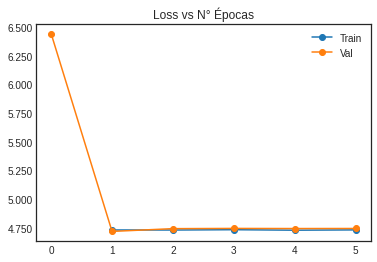

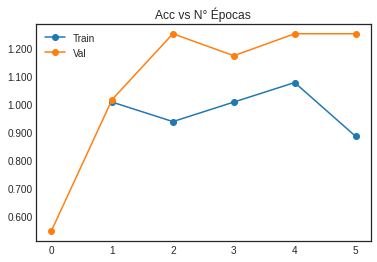

Train Loss: 4.7316 - Train Acc: 0.89%
Val Loss: 4.7440 - Val Acc: 1.25%
Test Loss: 4.7303 - Test Acc: 1.02%


In [34]:
train_dataset.transform = transforms.Compose([
     transforms.RandomApply([VerticalFlipTransform()], p=0.5),  
     transforms.Resize([224, 224]),
     to_normalized_tensor
])
val_dataset.transform = transforms.Compose([   
     transforms.Resize([224, 224]),
     to_normalized_tensor
])
test_dataset.transform = transforms.Compose([  
     transforms.Resize([224, 224]),
     to_normalized_tensor
])

ex_model = get_model(n_classes=n_classes)
ex_optimizer = Adam(ex_model.parameters(), lr=learning_rate)
ex_model = get_model(n_classes=n_classes)

ex_history = run_training(ex_model, loaders, ex_optimizer, criterion, n_epochs)
ex_test_performance = run_testing(ex_model, loaders['test'], criterion, n_epochs)

print_report(ex_history, ex_test_performance)

Inspeccionemos la predicción del modelo para un ejemplo.

Ground Truth
alpine sea holly

Top-5 Predictions
japanese anemone    (p=0.0212)
lotus               (p=0.0209)
mexican petunia     (p=0.0201)
fire lily           (p=0.0192)
orange dahlia       (p=0.0184)



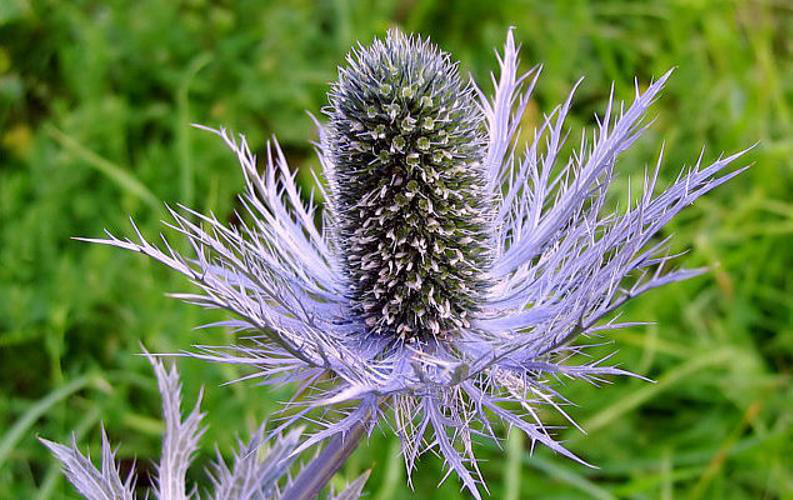

In [35]:
show_prediction(ex_model, test_dataset, sample_idx=166) # Si omiten el sample_idx este será elegido aleatoriamente

**Respuesta**

El modelo usando el flip vertical tiene muy bajo accuracy ( 1%), en comparacion con el modelo base (40%). Esto indica que el data augmentation usando random noice es mucho mas eficaz que usar una transformacion vertical. Una opcion es usar ambas transformaciones.

## Transfer Learning y Finetuning

Luego continuaremos explorando los métodos expuestos durante la clase, en esta caso aplicaremos transfer learning en la forma de finetuning.

En esta actividad aprovecharemos un modelo que previamente fue entrenado en el dataset [Imagenet](http://www.image-net.org/), el cual se ha vuelto prácticamente un standard en el área cuando se tiene en frente una tarea en imágenes. Utilizaremos el mismo modelo, ResNet18, que antes para mantener la consistencia y nuestros resultados sean comparables.

### Finetuning

Entrenemos un modelo haciendo finetuning de uno originalmente entrenado en Imagenet. Para esto es necesario conseguirnos los pesos de dicho modelo, por suerte PyTorch nos hace la vida fácil y con un simple parámetro podemos descargarlos automáticamente.

Para aprovechar los modelos de PyTorch debemos utilizar los modelos que vienen en [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html). Debemos crear un modelo llamando seteando el parámetro `pretrained=True`, esto automáticamente descargará (fijense en el *output* al momento de empezar crear el modelo) los pesos y los usará para el modelo. 

Es importante notar que la mayoría de estos modelos son preentrandos en Imagenet, pero hay algunos con otros datasets de origen, por lo que se recomienda revisar la documentación previamente a usar alguno de los modelos disponibles.

In [36]:
ft_model = models.resnet18(pretrained=True)
ft_model.fc = nn.Linear(in_features=512, out_features=n_classes, bias=True)
ft_model.to(device)
None # No queremos el output de la descripción del modelo en colab

Validating model before training
VAL-Batch 10/10 Loss: 4.8431 Acc: 0.55%
Epoch N°1
TRAIN-Batch 45/45 Loss: 1.7248 Acc: 64.51%
VAL-Batch 10/10 Loss: 0.6702 Acc: 83.36%
Epoch N°2
TRAIN-Batch 45/45 Loss: 0.2535 Acc: 94.55%
VAL-Batch 10/10 Loss: 0.3888 Acc: 87.03%
Epoch N°3
TRAIN-Batch 45/45 Loss: 0.0944 Acc: 97.45%
VAL-Batch 10/10 Loss: 0.2637 Acc: 90.47%
Epoch N°4
TRAIN-Batch 45/45 Loss: 0.0391 Acc: 98.32%
VAL-Batch 10/10 Loss: 0.2461 Acc: 90.08%
Epoch N°5
TRAIN-Batch 45/45 Loss: 0.0204 Acc: 98.52%
VAL-Batch 10/10 Loss: 0.1670 Acc: 91.88%
TEST-Batch 10/10 Loss: 0.1781 Acc: 95.62%

Test loss: 0.1781, Test acc.: 95.62



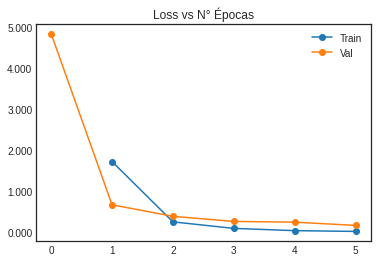

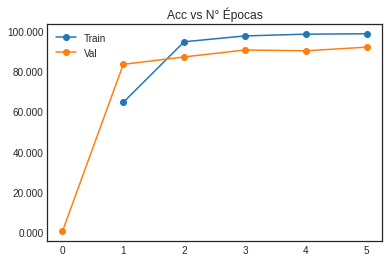

Train Loss: 0.0204 - Train Acc: 98.52%
Val Loss: 0.1670 - Val Acc: 91.88%
Test Loss: 0.1781 - Test Acc: 95.62%


In [37]:
learning_rate = 5e-4 # podríamos usar 0.01 la learning rate 1/10 de la original (para ResNet 0.1)
ft_optimizer = Adam(ft_model.parameters(), lr=learning_rate)

ft_history = run_training(ft_model, loaders, ft_optimizer, criterion, n_epochs)
ft_test_performance = run_testing(ft_model, loaders['test'], criterion, n_epochs)

print_report(ft_history, ft_test_performance)

Inspeccionemos la predicción del modelo para un ejemplo.

Ground Truth
alpine sea holly

Top-5 Predictions
bougainvillea       (p=0.9872)
sweet pea           (p=0.0049)
mallow              (p=0.0012)
cape flower         (p=0.0008)
siam tulip          (p=0.0005)



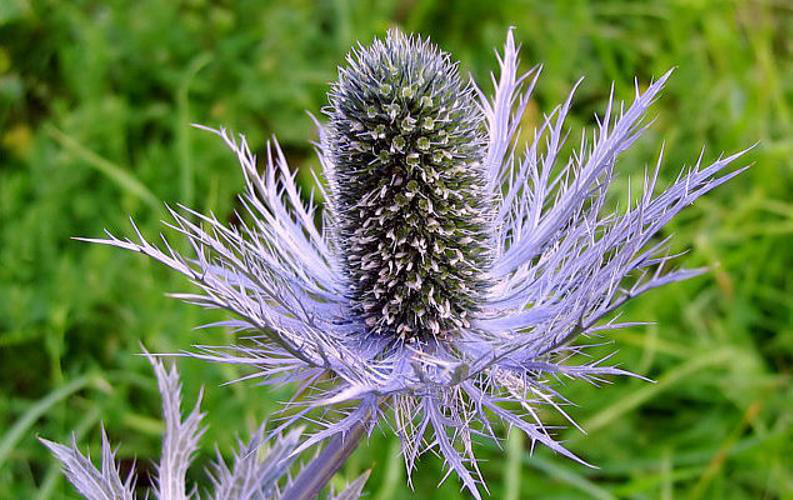

In [38]:
show_prediction(ft_model, test_dataset, sample_idx=166) # Si omiten el sample_idx este será elegido aleatoriamente

### **Ejercicio II**

- Haga una tabla resumen en donde muestre el rendimiento obtenido en los tres escenarios, base, usando data augmentation y usando finetuning, y en los 3 set de datos (train, val y test) distintos utilizados.
- Analice brevemente como se comparan los resultados. ¿Cuál escenario se llegó al mejor rendimiento? ¿Cuál es el que muestra mayor grado de sobreajuste?



**REspuesta**

Modelo base:
Train Loss: 1.7911 - Train Acc: 51.18%

Val Loss: 2.1614 - Val Acc: 40.23%

Test Loss: 2.1341 - Test Acc: 43.36%

Modelo Augmentation:

Train Loss: 1.9030 - Train Acc: 46.74%

Val Loss: 2.1958 - Val Acc: 40.78%

Test Loss: 2.1388 - Test Acc: 41.56%

Fine Tuning:

Train Loss: 0.0204 - Train Acc: 98.52%

Val Loss: 0.1670 - Val Acc: 91.88%

Test Loss: 0.1781 - Test Acc: 95.62%

**Comparacion**
Fine tuning es definitivamente el mejor modelo, mas que dobla el accuracy en test set en comparacion con los otros modelos. Ninguno de los modelos sufre de overfitting muy fuerte.



# Actividad II: Texto

En esta actividad aplicaremos lo que vimos en clase para un problema de clasificación de texto. En este caso veremos como usar finetuning para este dominio en particular.

**Importante.** Para facilitar su ejecución, esta sección puede ser ejecutada independientemente de la anterior.

<small>Basado en el notebook https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb

También agradecemos a Hernán Valdivieso por su script para descargar archivos desde Google Drive.</small>


## Preámbulo
Primero debemos montar nuestro drive, copiar el dataset hacia colab para luego decomprimirlo dentro del directorio data, que recién creamos. También importamos algunas de las librerías que ocuparemos durante esta actividad. 

En particular utilizaremos la libraría [*Transformers*](https://github.com/huggingface/transformers) de la empresa [HugginFace 🤗](https://huggingface.co), esta librería implementa varios de los modelos del tipo *transformer* que actualmente son de lo más utilizado para el dominio de NLP. Dentro de estos modelos destaca BERT, el cual es muy utilizado por su **buen rendimento al ser finetuneado**. 

Por el momento no entraremos en detalle de la arquitectura de *transformer*, pues lo verán en el futuro. Pero si les gana la curiosidad, les recomiendo leer el paper que los propuso, ["Attention is all you need"](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf) en NeurIPS 2017 y lo mismo con el paper de [BERT](https://arxiv.org/pdf/1810.04805.pdf) publicado en ACL 2019.

Este modelo de lenguaje será visto en otra sección del diplomado. 

In [1]:
!pip install -q transformers==3.5.1

In [2]:
![[ ! -f google_api.py ]] && wget -q --show-progress https://raw.githubusercontent.com/Hernan4444/MyScripts/master/google_drive/google_api.py
!mkdir -p data

In [3]:
import os
from google_api import download_file_without_authenticate

# Descargamos nuestros datos para ser utilizados en este notebook.
if not os.path.exists('lab4.zip'): 
    download_file_without_authenticate(
        '1NjcTV1SeZgYWOAZG-ig2NBpYP5EyTy8Z', 'data/jigsaw-toxic-comment-classification-challenge.zip')
    download_file_without_authenticate(
        '1ye0M-KnVtUbpIgGjogIjgWx0vReCthWA', 'data/flowers.zip')
    
!unzip -nq data/\*.zip -d data


2 archives were successfully processed.


In [4]:
!pip install -q transformers

In [5]:
import random
import numpy as np
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# No tocar este código
random.seed(1666)
rng_state = np.random.get_state()
np.random.seed(1666)
torch.manual_seed(1666)
torch.cuda.manual_seed(1666)

In [7]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn import metrics
import transformers
from transformers import BertTokenizer, BertModel

## Primeros Pasos

### Dataset

Trabajaremos con el dataset del desafío **Jigsaw's Multilingual Toxic Comment Classification**, este dataset está basado en comentarios realizados en Wikipedia y etiquetados por anotadores humanos dependiendo de su "toxicidad". Cada comentario tiene 6 etiquetas binarias, cada una independiente de las demás. Pueden obtener el dataset original de su [página del desafío en Kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data).

Primero que todo, como siempre debe ser, exploraremos los datos para tener una mejor idea de con qué estamos trabajando.

Dado que los datos están de forma tabular utilizaremos [`pandas`](https://pandas.pydata.org/docs/user_guide/index.html) como herramienta para ayudarnos en esta tarea.



In [8]:
df = pd.read_csv("./data/jigsaw-toxic-comment-classification-challenge/train.csv")
task_labels = list(df.columns[2:])

In [9]:
import textwrap

def print_sample(sample):
    def yesno(bool_):
      return 'yes' if bool_ else 'no'

    print('{:<13}: {}'.format('id', sample.id), end='\n\n')

    print('{:<13}:'.format('comment_text'))
    print(textwrap.fill(sample.comment_text, 50), end='\n\n')

    print('{:<13}: {}'.format('toxic', yesno(sample.toxic)))
    print('{:<13}: {}'.format('severe_toxic', yesno(sample.severe_toxic)))
    print('{:<13}: {}'.format('obscene', yesno(sample.obscene)))
    print('{:<13}: {}'.format('threat', yesno(sample.threat)))
    print('{:<13}: {}'.format('insult', yesno(sample.insult)))
    print('{:<13}: {}'.format('identity_hate', yesno(sample.identity_hate)))


sample = df.sample().iloc[0]
print_sample(sample)

id           : 157ed05fed7f1d77

comment_text :
the Public Policy Initiative Assessment Team wants
You! Hi Morphh,   I saw some of your contributions
on an article that falls within the scope of
Wikiproject: United States Public Policy,
(Taxation in the U.S.) you seem to have a lot
edits and expertise in policy and economics, and I
was hoping you would be interested in assessing
articles with the Public Policy Initiative. There
is more info about assessment on the  9/13/2010
Signpost. If you're interested or just curious you
can sign up on the  project page or just contact
me. Thanks!

toxic        : no
severe_toxic : no
obscene      : no
threat       : no
insult       : no
identity_hate: no


In [10]:
sample = df[df[df.columns[2:]].any(axis=1)].sample().iloc[0]
print_sample(sample)

id           : 71593f2890b5b365

comment_text :
Eric W.Bragg's Surrealism: SIDEWALK STAINS  In my
lifetime, I have seen some of the most stupidest
crap that my eyes have unfortunately seen!
However, this tops them all, Eric W.Bragg
presents, SIDEWALK STAINS! (I am not making this
up):  http://www.surrealcoconut.com/surrealism_gal
lery/Found_Objects/stain.html  In the meantime,
call Sanitation Enforcement to clean these
disgusting sidewalks and then call the police to
have Bragg locked up!

toxic        : yes
severe_toxic : no
obscene      : no
threat       : no
insult       : no
identity_hate: no


Algo importante que notar es que este dataset (para cada una de las tareas) está desbalanceado, en este caso significa que la cantidad de ejemplos negativos supera en gran medida a los ejemplos negativos. Veamos el desbalance imprimiendo la proporción de ejemplos positivos por cada tarea.

In [11]:
df[df.columns[2:]].sum() / len(df)

toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64

Definamos algunos parámetros que serán importante para el resto de esta actividad.

In [12]:
# Defining some key variables that will be used later on in the training
subset_size = 0.01 #@param {type:"slider", min:0, max:1, step:0.01}
max_len = 200 #@param {type: "number"}
batch_size = 32 #@param {type: "number"}
n_epochs = 5  #@param {type:"slider", min:1, max:20, step:1}
learning_rate = 1e-5 #@param {type: "number"}
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
df['list'] = df[df.columns[2:]].values.tolist()
new_df = df[['comment_text', 'list']].copy()
new_df = new_df.sample(frac=subset_size, random_state=200).reset_index(drop=True)

Antes de crear cada uno de nuestros objetos `Dataset`, debemos hacer la división de los distintos sets que utilizaremos (train, val y test).

In [14]:
train_size = 0.7
train_dataset = new_df.sample(frac=train_size, random_state=200)
test_dataset = new_df.drop(train_dataset.index).reset_index(drop=True)
val_dataset = test_dataset.sample(frac=0.5, random_state=200)
test_dataset = test_dataset.drop(val_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)
val_dataset = val_dataset.reset_index(drop=True)

In [15]:
for split, ds in [('train', train_dataset), ('val', val_dataset), ('test', test_dataset)]:
    print('{:<14s}{:>6,d}'.format(f'Dataset {split}:', len(ds)))

Dataset train: 1,117
Dataset val:     240
Dataset test:    239


Luego, debemos crear un objeto de la clase `Dataset` para utilizarlo en el entrenamiento. Para eso nos crearemos la clase `JigsawDataset` que nos ayudará con el manejo del dataset. 

In [16]:
from torch.utils.data import Dataset, DataLoader

class JigsawDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True,
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [17]:
training_set = JigsawDataset(train_dataset, tokenizer, max_len)
validating_set = JigsawDataset(val_dataset, tokenizer, max_len)
testing_set = JigsawDataset(test_dataset, tokenizer, max_len)

loaders = {
    'train': DataLoader(training_set, batch_size=batch_size, shuffle=True),
    'val': DataLoader(validating_set, batch_size=batch_size, shuffle=False),
    'test': DataLoader(testing_set, batch_size=batch_size, shuffle=False),
}

## Modelo Base

Para entrenar nuestros modelo, crearemos varias funciones para ayudarnos. Al igual que en la actividad anterior, les recomendamos que traten de entender cada una de estas funciones pues podrán solidificar conocimientos que ya han aprendido en el diplomado hasta ahora, pero para efectos de esta actividad no es necesario hacerlo.

In [18]:
def run_epoch(phase, model, loader, criterion, optimizer=None, return_predictions=False):
    n_batches = len(loader)
    if phase == 'train':
        model.train()
    elif phase == 'val' or 'test':
        model.eval()
        
    cum_loss = 0.0
    cum_acc = 0.0
    cum_preds = torch.zeros((0,6)).to(device)
    cum_targets = torch.zeros((0,6)).to(device)
    for n_batch, data in enumerate(loader, start=1):
        if phase == 'train': # Limpiamos los gradientes solo al entrenar
            optimizer.zero_grad()

        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)
        
        result = model(ids, mask, token_type_ids) # Aquí se ejecuta nuestro modelo

        loss = criterion(result, targets) # Cálculamos la pérdida
        cum_loss += loss.item()
        preds = torch.sigmoid(result) >= 0.5 # Nuestras predicciones positivas son todas las que pasan el umbral de 0.5

        cum_preds = torch.cat((cum_preds, preds))
        cum_targets = torch.cat((cum_targets, targets))

        # accuracy = calculate_metrics(targets, preds)
        cum_acc += torch.sum(preds == targets.data)
        if phase == 'train':
            loss.backward() # Hacemos backpropagation solo en train
            optimizer.step() # Actualizamos parámetros solo en train

        current_cum_loss = cum_loss / n_batch
        current_cum_acc = 100 * cum_acc / (n_batch * batch_size * 6) # son 6 tareas diferentes

        print(f'\r{phase.upper()}-Batch {n_batch}/{n_batches} '
              f'Loss: {current_cum_loss:.4f} '
              f'Acc: {current_cum_acc:.2f}% ', end='')
    
    epoch_loss = float(cum_loss / n_batch)
    epoch_acc = float(100 * cum_acc / (n_batch * batch_size * 6)) # son 6 tareas diferentes

    if return_predictions:
        return epoch_loss, epoch_acc, (cum_preds, cum_targets)

    return epoch_loss, epoch_acc

def calculate_metrics(targets, outputs):
    targets = targets.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()

    accuracy = 100 * metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    return accuracy, f1_score_micro, f1_score_macro

def run_training(model, loaders, optimizer, criterion, n_epochs):
    phases = ['train', 'val']
    history = {
        'train': {'loss': [], 'acc': []},
        'val': {'loss': [], 'acc': []}
    }

    print(f"Validating model before training")
    with torch.no_grad():
        val_loss, val_acc = run_epoch('val', model, loaders['val'], criterion)
    print()

    history['val']['loss'].append(val_loss)
    history['val']['acc'].append(val_acc)
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch N°{epoch}")
        for phase in phases:
            epoch_loss, epoch_acc = run_epoch(phase, model, loaders[phase], criterion, optimizer=optimizer)
            # Registramos las pérdidas y accuracy por época, por fase
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)
            print("")

    return history

def run_testing(model, loader, criterion, n_epochs):
    test_loss, test_acc, (outputs, targets) = run_epoch('test', model, loader, criterion, optimizer=optimizer, return_predictions=True)
    accuracy, f1_score_micro, f1_score_macro = calculate_metrics(targets, outputs)
    print(f'\n\nTest loss: {test_loss:.4f}, Test acc.: {test_acc:.2f}\n')
    return {'loss': test_loss, 'acc': accuracy, 'f1_micro': f1_score_micro,
            'f1_macro': f1_score_macro, 'outputs': outputs.cpu().numpy(), 'targets': targets.cpu().numpy()}

Definamos también algunas funciones que nos ayudarán a visualizar el entrenamiento y sus resultados de mejor forma.

In [19]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sklearn.metrics

def graph_metrics(metricas_test, metricas_train, title=''):
    fig, ax = plt.subplots()
    plt.style.use('seaborn-white')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
    plt.plot(range(1,int(len(metricas_train)+1)), metricas_train, marker='o')
    plt.plot(range(int(len(metricas_test))), metricas_test, marker='o')
    plt.legend(['Train', 'Val'])
    plt.title(title)
    plt.show()

def graph_training_metrics(history):
    for metric in ['loss', 'acc']:
        title = f'{metric.capitalize()} vs N° Épocas'
        graph_metrics(history['val'][metric], history['train'][metric], title=title)

def print_report(train_history, test_performance):
    graph_training_metrics(train_history)

    train_loss = train_history['train']['loss'][-1]
    train_acc = train_history['train']['acc'][-1]
    val_loss = train_history['val']['loss'][-1]
    val_acc = train_history['val']['acc'][-1]
    test_loss = test_performance['loss']
    test_acc = test_performance['acc']
    print(f'Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%')

def plot_cm(ax, cm, task, labels):
    cax = ax.matshow(cm, cmap='Blues')
    plt.title(f'Confusion matrix of the {task} task')
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)

    for i in range(len(cm)):
        for j in range(len(cm[0,:])):
            color = 'k' if cm[i, j] < 0.5 else 'w'
            pct = f'{cm[i, j]:.4f}'
            text = ax.text(j, i, pct, ha='center', va='center', color=color, fontsize=14)

    plt.xlabel('Predicted')
    plt.ylabel('True')

def plot_confusions(outputs, targets, labels):
    ncols, nrows = 3, 2
    fig = plt.figure(figsize=[6.4*0.75*ncols, 4.8*1*nrows])
    for task_idx, task in enumerate(labels):
        confusion_matrix = sklearn.metrics.confusion_matrix(outputs[:, task_idx], targets[:, task_idx], normalize='true')
        
        task_labels = [f'non {task}', task]
        ax = fig.add_subplot(nrows, ncols, task_idx + 1)
        plot_cm(ax, confusion_matrix, task, task_labels)

    fig.tight_layout(h_pad=1.5, w_pad=1.5)
    plt.show()

def bold(text):
  return '\033[1m' + text + '\033[0m'

def show_prediction(model, dataset, sample_idx=None):
    if sample_idx is None:
        sample_idx = random.randrange(len(dataset))

    text = dataset.comment_text[sample_idx]
    targets = dataset.targets[sample_idx]
    sample = dataset[sample_idx]

    ids = sample['ids'].to(device, dtype=torch.long).unsqueeze(dim=0)
    mask = sample['mask'].to(device, dtype=torch.long).unsqueeze(dim=0)
    token_type_ids = sample['token_type_ids'].to(device, dtype=torch.long).unsqueeze(dim=0)
    targets = sample['targets'].to(device, dtype=torch.float).unsqueeze(dim=0)

    result = model(ids, mask, token_type_ids) # Aquí se ejecuta nuestro modelo
    results = list(torch.nn.functional.sigmoid(result).squeeze())
    targets = list(targets.squeeze())

    def yesno(bool_):
        return 'yes' if bool_ else 'no'

    tasks =  ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    print(textwrap.fill(text, 50), end='\n\n')
    print('{:>17}  {:>14s} {:>8s}'.format('Task', 'Prediction', "Real"))
    for task, prob, gt in zip(tasks, results, targets):
        task_pred = yesno(prob > 0.5)
        gt = yesno(gt == 1)
        print('{:>17}  {:>5s} (p={:.4f}) {:>5s}'.format(task, task_pred, prob, gt))

Ocuparemos un modelo que definimos nosotros `BERTClass`, el cual toma el modelo de BERT preentrenado que nos entrega la librería `transformers` y le agregamos capas lineales para realizar la clasificación de nuestras tareas.

In [20]:
from transformers import PretrainedConfig

class BERTClass(torch.nn.Module):
    def __init__(self, pretrained=True):
        super(BERTClass, self).__init__()
        if pretrained:
            self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        else:
            config = PretrainedConfig.from_pretrained('bert-base-uncased')
            self.l1 = transformers.BertModel(config)

        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1 = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

Entrenamos nuestro modelo base.


Validating model before training
VAL-Batch 8/8 Loss: 0.7226 Acc: 32.42% 
Epoch N°1
TRAIN-Batch 35/35 Loss: 0.2163 Acc: 94.64% 
VAL-Batch 8/8 Loss: 0.1241 Acc: 91.28% 
Epoch N°2
TRAIN-Batch 35/35 Loss: 0.1498 Acc: 96.12% 
VAL-Batch 8/8 Loss: 0.1157 Acc: 91.28% 
Epoch N°3
TRAIN-Batch 35/35 Loss: 0.1464 Acc: 96.12% 
VAL-Batch 8/8 Loss: 0.1125 Acc: 91.28% 
Epoch N°4
TRAIN-Batch 35/35 Loss: 0.1445 Acc: 96.12% 
VAL-Batch 8/8 Loss: 0.1124 Acc: 91.28% 
Epoch N°5
TRAIN-Batch 35/35 Loss: 0.1425 Acc: 96.12% 
VAL-Batch 8/8 Loss: 0.1115 Acc: 91.28% 
TEST-Batch 8/8 Loss: 0.1568 Acc: 89.71% 

Test loss: 0.1568, Test acc.: 89.71



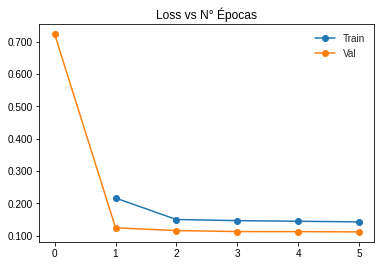

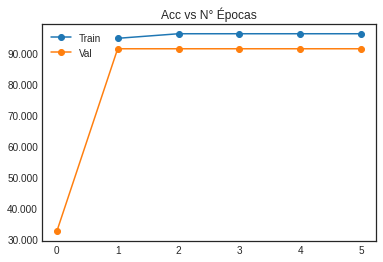

Train Loss: 0.1425 - Train Acc: 96.12%
Val Loss: 0.1115 - Val Acc: 91.28%
Test Loss: 0.1568 - Test Acc: 89.96%


In [21]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

model = BERTClass(pretrained=False)
model.to(device)

criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

history = run_training(model, loaders, optimizer, criterion, n_epochs)
test_performance = run_testing(model, loaders['test'], criterion, n_epochs)

print_report(history, test_performance)

Y podemos evaluar nuestros resultado. Dado que nuestros datos tienen un problema de desbalance, utilizaremos la meetrica [*F-1 Score*](https://en.wikipedia.org/wiki/F1_score) en vez de la tradicional *accuracy*. También nos apoyaremos visualmente de las [matrices de confusión](https://es.wikipedia.org/wiki/Matriz_de_confusi%C3%B3n) que obtenemos con nuestras predicciones.

In [22]:
for metric in ['acc', 'f1_micro', 'f1_macro']:
    metric_str = str.capitalize(metric.replace('_', ' '))
    print('{:<9}: {:.4f}'.format(metric_str, test_performance[metric]))

Acc      : 89.9582
F1 micro : 0.0000
F1 macro : 0.0000


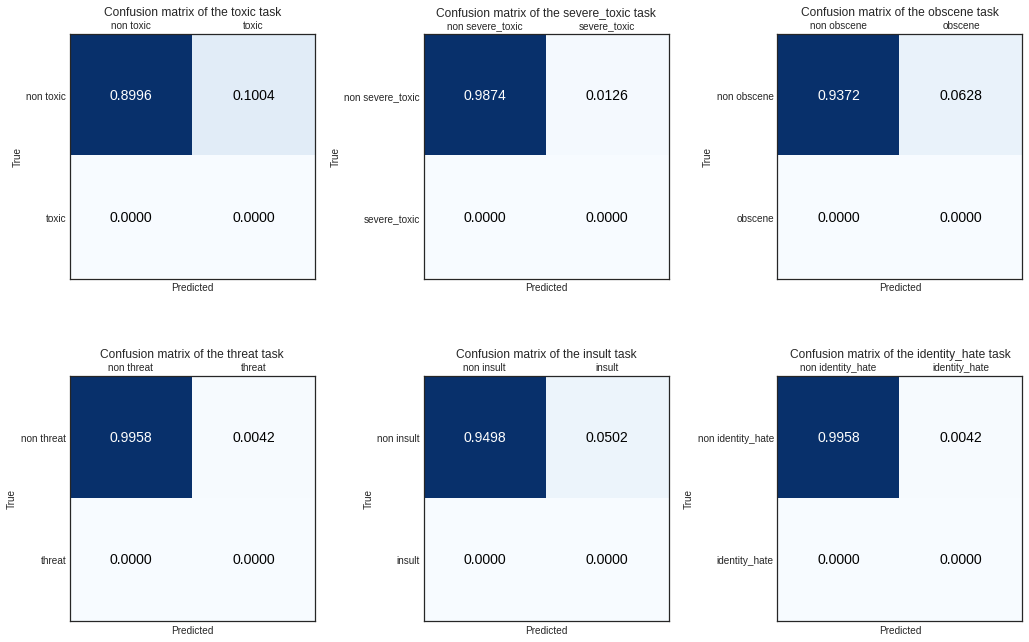

In [23]:
outputs = test_performance['outputs']
targets = test_performance['targets']
plot_confusions(outputs, targets, task_labels)

Inspeccionemos la predicción para un ejemplo.

In [24]:
show_prediction(model, training_set, sample_idx=566) # Si omiten el sample_idx este será elegido aleatoriamente

and i admit that i'm to sensitive

             Task      Prediction     Real
            toxic     no (p=0.1010)    no
     severe_toxic     no (p=0.0168)    no
          obscene     no (p=0.0670)    no
           threat     no (p=0.0109)    no
           insult     no (p=0.0616)    no
    identity_hate     no (p=0.0132)    no


El siguiente código es para liberar la memoria de la GPU, luego del entrenamineto. Así no tendremos errores por que se nos acaba la memoria.

In [25]:
model = criterion = optimizer = None

## Finetuning

Finalmente realizamos el mismo ejercicio que el anterior pero en vez de entrenar el modelo desde cero, lo entrenaremos utilizando los pesos preentrenados de BERT.


Validating model before training
VAL-Batch 8/8 Loss: 0.6785 Acc: 47.07% 
Epoch N°1
TRAIN-Batch 35/35 Loss: 0.3802 Acc: 89.42% 
VAL-Batch 8/8 Loss: 0.1917 Acc: 91.28% 
Epoch N°2
TRAIN-Batch 35/35 Loss: 0.1811 Acc: 96.12% 
VAL-Batch 8/8 Loss: 0.1257 Acc: 91.28% 
Epoch N°3
TRAIN-Batch 35/35 Loss: 0.1302 Acc: 96.31% 
VAL-Batch 8/8 Loss: 0.0909 Acc: 91.99% 
Epoch N°4
TRAIN-Batch 35/35 Loss: 0.0874 Acc: 97.68% 
VAL-Batch 8/8 Loss: 0.0703 Acc: 92.12% 
Epoch N°5
TRAIN-Batch 35/35 Loss: 0.0615 Acc: 98.12% 
VAL-Batch 8/8 Loss: 0.0635 Acc: 91.93% 
TEST-Batch 8/8 Loss: 0.0681 Acc: 91.47% 

Test loss: 0.0681, Test acc.: 91.47



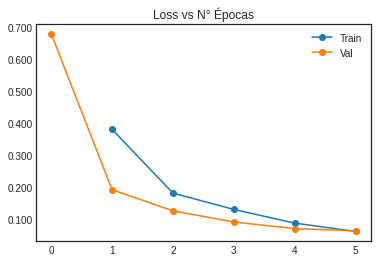

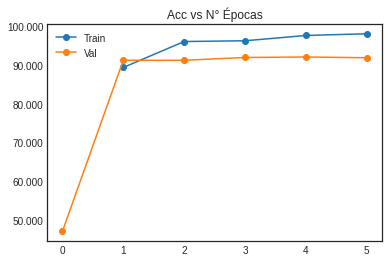

Train Loss: 0.0615 - Train Acc: 98.12%
Val Loss: 0.0635 - Val Acc: 91.93%
Test Loss: 0.0681 - Test Acc: 90.79%


In [26]:
learning_rate = 2e-5
ft_model = BERTClass(pretrained=True)
ft_model.to(device)

criterion = BCEWithLogitsLoss()
ft_optimizer = Adam(ft_model.parameters(), lr=learning_rate)

ft_history = run_training(ft_model, loaders, ft_optimizer, criterion, n_epochs)
ft_test_performance = run_testing(ft_model, loaders['test'], criterion, n_epochs)

print_report(ft_history, ft_test_performance)

In [27]:
for metric in ['acc', 'f1_micro', 'f1_macro']:
    metric_str = str.capitalize(metric.replace('_', ' '))
    print('{:<9}: {:.4f}'.format(metric_str, ft_test_performance[metric]))

Acc      : 90.7950
F1 micro : 0.7238
F1 macro : 0.3897


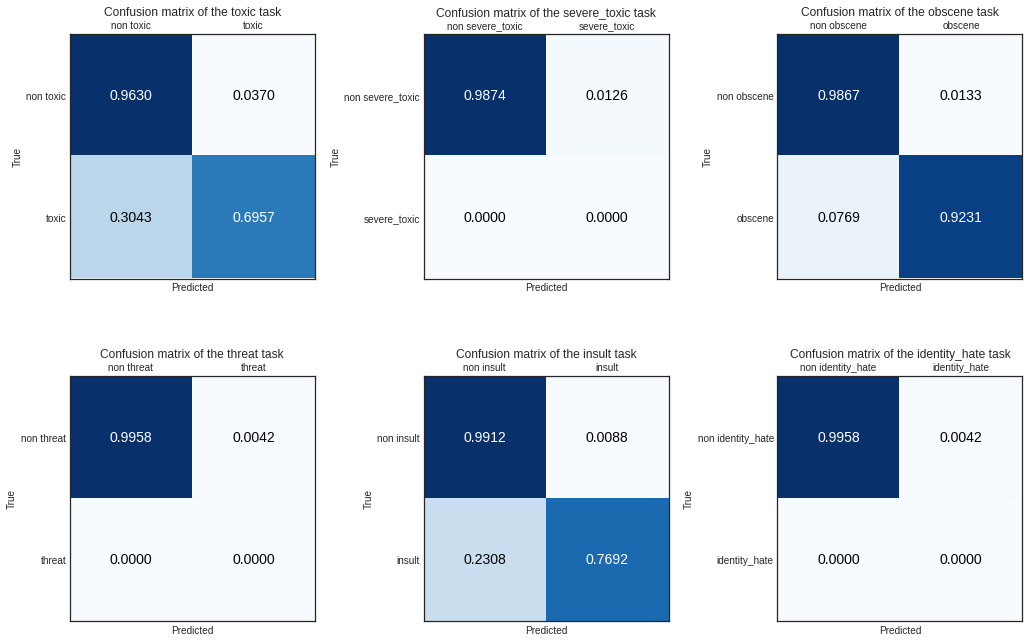

In [28]:
outputs = ft_test_performance['outputs']
targets = ft_test_performance['targets']
plot_confusions(outputs, targets, task_labels)

Inspeccionemos la predicción para un ejemplo.

In [29]:
show_prediction(ft_model, training_set, sample_idx=566) # Si omiten el sample_idx este será elegido aleatoriamente

and i admit that i'm to sensitive

             Task      Prediction     Real
            toxic     no (p=0.0193)    no
     severe_toxic     no (p=0.0202)    no
          obscene     no (p=0.0155)    no
           threat     no (p=0.0174)    no
           insult     no (p=0.0171)    no
    identity_hate     no (p=0.0155)    no


## **Ejercicio III**

Cree un modelo nuevo para realizar finetuning y pruebelo con **tres** learning rates superiores a la que utilizamos por defecto. 
- Analice brevemente el entrenamiento de los modelos (gráficos con las curvas de pérdida y *accuracy* por época), qué diferencias ve en estos.
- Analice el brevemente rendimiento en el set de test medido según la métrica *Macro F1-Score*, además tome en consideración las matrices de confusión en su análisis.

In [33]:
model = criterion = optimizer = None

In [38]:
torch.cuda.empty_cache()

In [39]:
learning_rate = 1e-1
ex_model = BERTClass(pretrained=True)
ex_model.to(device)

criterion = BCEWithLogitsLoss()
ex_optimizer = Adam(ex_model.parameters(), lr=learning_rate)

ex_history = run_training(ex_model, loaders, ex_optimizer, criterion, n_epochs)
ex_test_performance = run_testing(ex_model, loaders['test'], criterion, n_epochs)

print_report(ex_history, ex_test_performance)

##########
for metric in ['acc', 'f1_micro', 'f1_macro']:
    metric_str = str.capitalize(metric.replace('_', ' '))
    print('{:<9}: {:.4f}'.format(metric_str, ex_test_performance[metric]))

outputs = ex_test_performance['outputs']
targets = ex_test_performance['targets']
plot_confusions(outputs, targets, task_labels)
#############

show_prediction(ex_model, training_set, sample_idx=566) # Si omiten el sample_idx este será elegido aleatoriamente

RuntimeError: ignored

**Problema**
Lamentablemente no se como arreglar este problema de memoria

In [ ]:
learning_rate = 1e-2
ex_model = BERTClass(pretrained=True)
ex_model.to(device)

criterion = BCEWithLogitsLoss()
ex_optimizer = Adam(ex_model.parameters(), lr=learning_rate)

ex_history = run_training(ex_model, loaders, ex_optimizer, criterion, n_epochs)
ex_test_performance = run_testing(ex_model, loaders['test'], criterion, n_epochs)

print_report(ex_history, ex_test_performance)

##########
for metric in ['acc', 'f1_micro', 'f1_macro']:
    metric_str = str.capitalize(metric.replace('_', ' '))
    print('{:<9}: {:.4f}'.format(metric_str, ex_test_performance[metric]))

outputs = ex_test_performance['outputs']
targets = ex_test_performance['targets']
plot_confusions(outputs, targets, task_labels)
#############

show_prediction(ex_model, training_set, sample_idx=566) # Si omiten el sample_idx este será elegido aleatoriamente

In [ ]:
learning_rate = 1e-3
ex_model = BERTClass(pretrained=True)
ex_model.to(device)

criterion = BCEWithLogitsLoss()
ex_optimizer = Adam(ex_model.parameters(), lr=learning_rate)

ex_history = run_training(ex_model, loaders, ex_optimizer, criterion, n_epochs)
ex_test_performance = run_testing(ex_model, loaders['test'], criterion, n_epochs)

print_report(ex_history, ex_test_performance)

##########
for metric in ['acc', 'f1_micro', 'f1_macro']:
    metric_str = str.capitalize(metric.replace('_', ' '))
    print('{:<9}: {:.4f}'.format(metric_str, ex_test_performance[metric]))

outputs = ex_test_performance['outputs']
targets = ex_test_performance['targets']
plot_confusions(outputs, targets, task_labels)
#############

show_prediction(ex_model, training_set, sample_idx=566) # Si omiten el sample_idx este será elegido aleatoriamente

# Anexo


## ¿Cómo entrenar algunas capas del modelo?

Para poder congelar capas en una red para que no sean entrenadas solo debemos setear como false el atributo de dichos parámetros, como se muestra a continuación. deben copiar y adaptar este snippet de código para el caso que les interese.

En particular deben setear como `False` el campo `requires_grad` de los parámetros que quieren congelar.

In [ ]:
# # Con esto congelamos todas las capas
# for param in model.parameters():
#     param.requires_grad = False

# model.fc.requires_grad = True # Descongelamos las capas que queremos entrenar